In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from utils.lightgbm_model import LightGBMModel, ModelManager
from utils.data_loader import DataLoader
from utils.preprocessing import DataPreprocessor
from config import Settings

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100


In [2]:
config = Settings()

# Load data
data_loader = DataLoader(config.data_path)
data_loader.load_data()

# Preprocess data 
preprocessor = DataPreprocessor(data_loader.data, config)

X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.preprocess()


2024-08-04 20:25:40,766 - INFO - Loading data from file: ../data/loan_approval_dataset_updated.csv
2024-08-04 20:25:40,787 - INFO - Data loaded successfully
2024-08-04 20:25:40,788 - INFO - Dataset shape: (4269, 14)
2024-08-04 20:25:40,794 - INFO - Data Overview:
| loan_id   | no_of_dependents   | City   | education    | self_employed   | income_annum   | loan_amount   | loan_term   | cibil_score   | residential_assets_value   | commercial_assets_value   | luxury_assets_value   | bank_asset_value   | loan_status   |
|:----------|:-------------------|:-------|:-------------|:----------------|:---------------|:--------------|:------------|:--------------|:---------------------------|:--------------------------|:----------------------|:-------------------|:--------------|
| 1         | 2                  | Ankara | Graduate     | No              | 9600000        | 29900000      | 12          | 778           | 2.4e+06                    | 17600000                  | 22700000              |

- The distribution of loan statuses is unbalanced. The number of rejected applications may be significantly higher than approved ones. This require special considerations during modelling to avoid bias. 
- ***city***, ***education*** and ***cibil_score*** have missing values, with cibil_score being mostly affected. 

**Outliers**
- ***income_annum:*** Min 200K is significantly lower than the 0.25 perc suggesting potential outliers or errors.
- ***residential_asset_value:*** negative asses min value is likely an error/maybe needs correction (-100k).

- Incomes and asset values are likely right-skewed with few high values. 
- ***cibil_score*** appears to be normally distributed, which is good. 

**Target Distribution**
- The dataset is imbalanced. %62 approved, %38 rejected. 

In [3]:
#train the model
lgbm_model = LightGBMModel(params=config.params)
model, feature_importances = lgbm_model.train(X_train, y_train, X_val, y_val)


2024-08-04 20:25:48,762 - INFO - Starting training process.
2024-08-04 20:25:48,896 - INFO - Training completed. Generating predictions.
2024-08-04 20:25:48,900 - INFO - Evaluating model performance.
2024-08-04 20:25:48,907 - INFO - Accuracy: 1.0
2024-08-04 20:25:48,908 - INFO - F1: 0.9599
2024-08-04 20:25:48,908 - INFO - Precision: 0.9611
2024-08-04 20:25:48,909 - INFO - Recall: 0.9587
2024-08-04 20:25:48,910 - INFO - ROC: 0.9927
2024-08-04 20:25:48,928 - INFO - Retrieving feature importances.
2024-08-04 20:25:48,933 - INFO - Feature importances retrieved successfully.
2024-08-04 20:25:48,934 - INFO - Model training and evaluation completed.


Training until validation scores don't improve for 5 rounds
[10]	training's binary_logloss: 0.352429	valid_1's binary_logloss: 0.3574
[20]	training's binary_logloss: 0.218136	valid_1's binary_logloss: 0.235356
[30]	training's binary_logloss: 0.142347	valid_1's binary_logloss: 0.161496
[40]	training's binary_logloss: 0.107587	valid_1's binary_logloss: 0.132138
[50]	training's binary_logloss: 0.0875315	valid_1's binary_logloss: 0.122714
[60]	training's binary_logloss: 0.0737803	valid_1's binary_logloss: 0.115792
[70]	training's binary_logloss: 0.0605585	valid_1's binary_logloss: 0.107556
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.0566203	valid_1's binary_logloss: 0.106895


			 Evaluation
Accuracy: 1.0
F1: 0.9599
Precision: 0.9611
Recall: 0.9587
ROC: 0.9927
			 Classification Report
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       228
           1       0.96      0.96      0.96       412

    accuracy      

In [4]:
# Evaluate the model
lgbm_model.evaluate_model(y_val, model.predict(X_val))

# Save the trained model
today_date = datetime.today().strftime('%Y-%m-%d')
model_path = config.model_dir / f"trained_model_{today_date}.pkl"
lgbm_model.save_model(model_path)

print(f"Model saved to {model_path}")


2024-08-04 20:25:49,307 - INFO - Evaluating model performance.
2024-08-04 20:25:49,319 - INFO - Accuracy: 1.0
2024-08-04 20:25:49,320 - INFO - F1: 0.9599
2024-08-04 20:25:49,321 - INFO - Precision: 0.9611
2024-08-04 20:25:49,322 - INFO - Recall: 0.9587
2024-08-04 20:25:49,323 - INFO - ROC: 0.9929
2024-08-04 20:25:49,340 - INFO - Saving the model to ../models/trained_model_2024-08-04.pkl
2024-08-04 20:25:49,346 - INFO - Model saved successfully to ../models/trained_model_2024-08-04.pkl




			 Evaluation
Accuracy: 1.0
F1: 0.9599
Precision: 0.9611
Recall: 0.9587
ROC: 0.9929
			 Classification Report
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       228
           1       0.96      0.96      0.96       412

    accuracy                           0.95       640
   macro avg       0.94      0.94      0.94       640
weighted avg       0.95      0.95      0.95       640

Model saved to ../models/trained_model_2024-08-04.pkl


<AxesSubplot:title={'center':'Feature Importance (split)'}, ylabel='feature'>

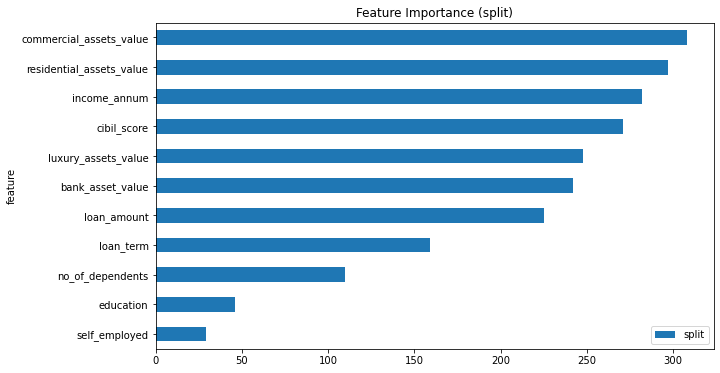

In [5]:
feature_importances.reset_index().sort_values("split").plot(
    kind="barh", x="feature", y="split", title="Feature Importance (split)", figsize=(10, 6)
)


<AxesSubplot:title={'center':'Feature Importance (Gain)'}, ylabel='feature'>

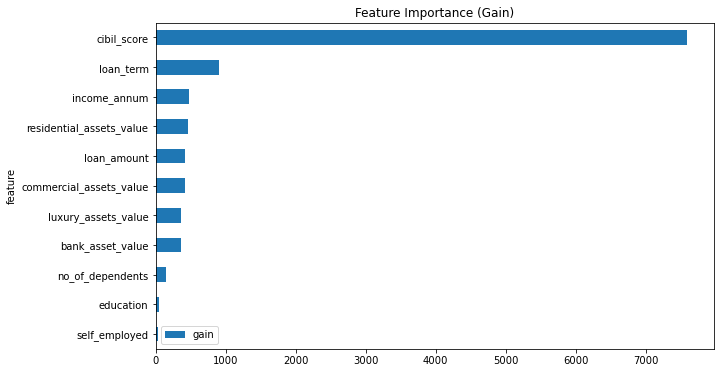

In [6]:
feature_importances.reset_index().sort_values("gain").plot(
    kind="barh", x="feature", y="gain", title="Feature Importance (Gain)", figsize=(10, 6)
)
